In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
!pip install tensorflow-quantum==0.7.3
!pip install tensorflow==2.15.0
import importlib
import pkg_resources
importlib.reload(pkg_resources)
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics, losses, optimizers
%matplotlib inline
from cirq.contrib.svg import SVGCircuit
pd.set_option('future.no_silent_downcasting', True)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
data = pd.read_csv('BO_Training_Dataset.csv')

print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print("Number of categorical featues including Product id and target variable : " , data.select_dtypes(exclude=['int', 'float']).shape[1])
print('Features : ', data.columns.values)

Number of data points :  1048575
Number of features :  23
Number of categorical featues including Product id and target variable :  7
Features :  ['sku' 'national_inv' 'lead_time' 'in_transit_qty' 'forecast_3_month'
 'forecast_6_month' 'forecast_9_month' 'sales_1_month' 'sales_3_month'
 'sales_6_month' 'sales_9_month' 'min_bank' 'potential_issue'
 'pieces_past_due' 'perf_6_month_avg' 'perf_12_month_avg' 'local_bo_qty'
 'deck_risk' 'oe_constraint' 'ppap_risk' 'stop_auto_buy' 'rev_stop'
 'went_on_backorder']


In [ ]:
data= data[:50000]

In [ ]:
data = data.drop(columns=['sku'])

num_features = data.select_dtypes(include=['float64', 'int64'])
data.loc[:, 'perf_12_month_avg'] = data['perf_12_month_avg'].replace(-99.0, np.nan)
data.loc[:, 'perf_6_month_avg'] = data['perf_6_month_avg'].replace(-99.0, np.nan)

imputer = IterativeImputer(random_state=2024)
df_imputed = pd.DataFrame(imputer.fit_transform(num_features), columns=num_features.columns)

skewness = df_imputed.skew()
print("Skewness:\n", skewness)

df_transformed = PowerTransformer(method='yeo-johnson').fit_transform(df_imputed)
df_transformed = pd.DataFrame(df_transformed, columns=df_imputed.columns)

scaler = RobustScaler()
df_scaled_num = pd.DataFrame(scaler.fit_transform(df_transformed), columns=df_transformed.columns)

cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    data[col] = data[col].replace({'No': 0.0, 'Yes': 1.0})
    data[col] = data[col].fillna(-1).astype(int)

df_final = pd.concat([df_scaled_num, data[cat_cols]], axis=1)
df_final.info()

Skewness:
 national_inv         219.791728
lead_time              4.309722
in_transit_qty       127.284487
forecast_3_month     139.139632
forecast_6_month     143.040866
forecast_9_month     139.756086
sales_1_month        120.366694
sales_3_month        109.846240
sales_6_month        114.630824
sales_9_month        105.200642
min_bank             123.089131
pieces_past_due      136.182197
perf_6_month_avg      -3.139691
perf_12_month_avg     -3.265073
local_bo_qty         123.937608
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national_inv       50000 non-null  float64
 1   lead_time          50000 non-null  float64
 2   in_transit_qty     50000 non-null  float64
 3   forecast_3_month   50000 non-null  float64
 4   forecast_6_month   50000 non-null  float64
 5   forecast_9_month   50000 non-null  float64
 

In [ ]:
dataX = df_final.copy().drop(['went_on_backorder'],axis=1)
dataY = df_final['went_on_backorder'].copy()
print(f"dataX shape: {dataX.shape}")
print(f"dataY shape: {dataY.shape}")

print(dataY.value_counts())

dataX shape: (50000, 21)
dataY shape: (50000,)
went_on_backorder
0    49498
1      502
Name: count, dtype: int64


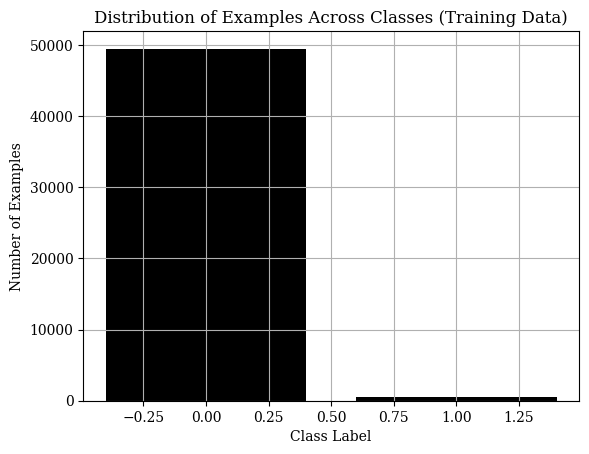

In [ ]:
class_labels, class_counts = np.unique(dataY, return_counts=True)

plt.bar(class_labels, class_counts, color='k')
plt.xlabel('Class Label')
plt.ylabel('Number of Examples')
plt.title('Distribution of Examples Across Classes (Training Data)')
plt.grid()
plt.show()

## **Variation inflation factor**

In [ ]:
def calculate_vif(df, threshold=5):
    """Calculate VIF and iteratively remove features with high VIF values."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    while vif_data["VIF"].max() > threshold:
        max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        print(f"Removing {max_vif_feature} with VIF {vif_data['VIF'].max():.2f}")

        # Drop the feature with the highest VIF
        df = df.drop(columns=[max_vif_feature])

        # Recalculate VIF
        vif_data = pd.DataFrame()
        vif_data["Feature"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    print("Final features after VIF elimination:")
    print(vif_data)
    return df

dataX_reduced = calculate_vif(dataX.copy())
X_train, X_test, y_train, y_test = train_test_split(
    dataX_reduced, dataY, test_size=0.33, random_state=2024, stratify=dataY)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Removing sales_6_month with VIF 55.18
Removing forecast_6_month with VIF 27.92
Removing sales_3_month with VIF 20.50
Removing perf_12_month_avg with VIF 12.27
Removing sales_1_month with VIF 8.85
Removing forecast_9_month with VIF 7.97
Final features after VIF elimination:
             Feature       VIF
0       national_inv  1.025048
1          lead_time  1.067885
2     in_transit_qty  2.280936
3   forecast_3_month  2.336416
4      sales_9_month  2.386766
5           min_bank  3.754253
6    pieces_past_due  1.062057
7   perf_6_month_avg  1.173806
8       local_bo_qty  1.073694
9    potential_issue  1.004960
10         deck_risk  1.456493
11     oe_constraint  1.001922
12         ppap_risk  1.144044
13     stop_auto_buy  2.821066
14          rev_stop  1.002246
X_train shape: (33500, 15), X_test shape: (16500, 15)
y_train shape: (33500,), y_test shape: (16500,)


In [ ]:
X_train_min = X_train.min()
X_train_max = X_train.max()
X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
X_test_normalized = X_test_normalized.clip(0, 1)

In [ ]:
import math

num_qubits = math.ceil(math.log2(X_train_normalized.shape[1]))
print(num_qubits)

4


In [ ]:
qubits = [cirq.GridQubit(0, i) for i in range(num_qubits)]
symbols = sympy.symbols(f'theta(0:{num_qubits})')

X_train_quantum = np.zeros((X_train_normalized.shape[0], num_qubits))

for i in range(num_qubits):
    # Using 2π * normalized value to map it to angle range
    X_train_quantum[:, i] = 2 * np.pi * X_train_normalized.iloc[:, i]

print("Quantum Features Shape:", X_train_quantum.shape)

Quantum Features Shape: (33500, 4)


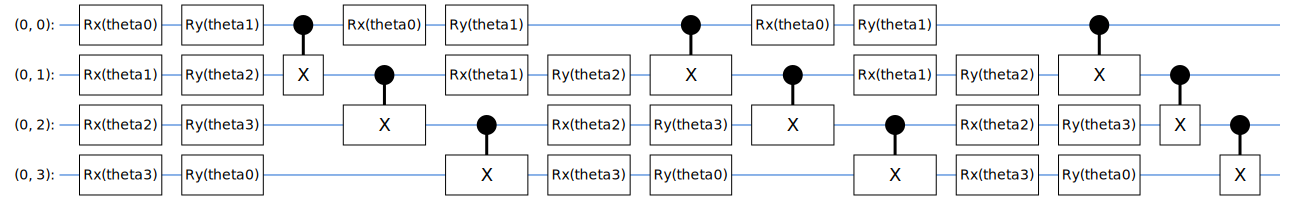

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import cirq

def create_quantum_circuit(qubits, symbols, num_layers=3):
    circuit = cirq.Circuit()
    for _ in range(num_layers):
        for i, qubit in enumerate(qubits):
            circuit.append(cirq.rx(symbols[i % len(symbols)])(qubit))
            circuit.append(cirq.ry(symbols[(i + 1) % len(symbols)])(qubit))
        # Entanglement
        for i in range(len(qubits) - 1):
            circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
    return circuit
quantum_circuit = create_quantum_circuit(qubits, symbols)
operators = [cirq.Z(q) for q in qubits]
quantum_layer = tfq.layers.PQC(quantum_circuit, operators)
SVGCircuit(quantum_circuit)

In [ ]:
METRICS = [
    # tf.keras.metrics.BinaryCrossentropy(name='cross_entropy'),
    tf.keras.metrics.MeanSquaredError(name='brier_score'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')]

In [ ]:
def hybrid_model(classical_input_dim, quantum_input_dim, metrics=METRICS, output_bias=None):
    random_uniform_initializer = tf.keras.initializers.RandomUniform(seed=42)
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    classical_input = tf.keras.layers.Input(shape=(classical_input_dim,), name='classical_input')

    quantum_input = tf.keras.layers.Input(shape=(quantum_input_dim,), name='quantum_input')
    batch_size = tf.shape(quantum_input)[0]
    tiled_circuits = tfq.convert_to_tensor([quantum_circuit])
    tiled_up_circuits = tf.repeat(tiled_circuits, repeats=batch_size, axis=0)
    symbol_names = [str(s) for s in symbols]
    resolved_circuits = tfq.resolve_parameters(tiled_up_circuits, symbol_names, quantum_input)
    quantum_output = quantum_layer(resolved_circuits)

    combined = tf.keras.layers.Concatenate()([classical_input, quantum_output])

    # Neural network layers
    x = tf.keras.layers.Dense(512, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(256, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(x) # Changed 'LeakyRelu' to 'LeakyReLU'
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(x) # Changed 'LeakyRelu' to 'LeakyReLU'
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(x) # Changed 'LeakyRelu' to 'LeakyReLU'
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(x) # Changed 'LeakyRelu' to 'LeakyReLU'
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(16, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(x) # Changed 'LeakyRelu' to 'LeakyReLU'
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
    model = tf.keras.Model(inputs=[classical_input, quantum_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model

In [ ]:
def early_stopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor='auc',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

input_dim = X_train_normalized.shape[1]
quantum_input_dim = num_qubits

model = hybrid_model(input_dim, quantum_input_dim)
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 quantum_input (InputLayer)  [(None, 4)]                  0         []                            
                                                                                                  
 tf.compat.v1.shape_13 (TFO  (2,)                         0         ['quantum_input[0][0]']       
 pLambda)                                                                                         
                                                                                                  
 tf.__operators__.getitem_1  ()                           0         ['tf.compat.v1.shape_13[0][0]'
 3 (SlicingOpLambda)                                                ]                             
                                                                                           

In [ ]:
!pip install graphviz
import graphviz

def visualize_model_graph(model):
    dot = graphviz.Digraph(format='png')
    dot.node('Input', 'Input Layer\n' + str(input_dim) + ' Features', shape='box', color='lightblue')

    for idx, layer in enumerate(model.layers):
        layer_name = layer.name
        if isinstance(layer, layers.Dense):
            dot.node(layer_name, f'{layer_name}\n{layer.units} Neurons', shape='ellipse')
        elif isinstance(layer, layers.Dropout):
            dot.node(layer_name, layer_name, shape='diamond')

        if idx == 0:
            dot.edge('Input', layer_name)
        else:
            dot.edge(model.layers[idx - 1].name, layer_name)

    output_layer = model.layers[-1].name
    dot.node('Output', 'Output Layer\n1 Neuron', shape='ellipse', color='lightgreen')
    dot.edge(output_layer, 'Output')

    return dot

dnn_graph = visualize_model_graph(model)
dnn_graph.render('dnn_model_graph')
dnn_graph.view()

'dnn_model_graph.png'

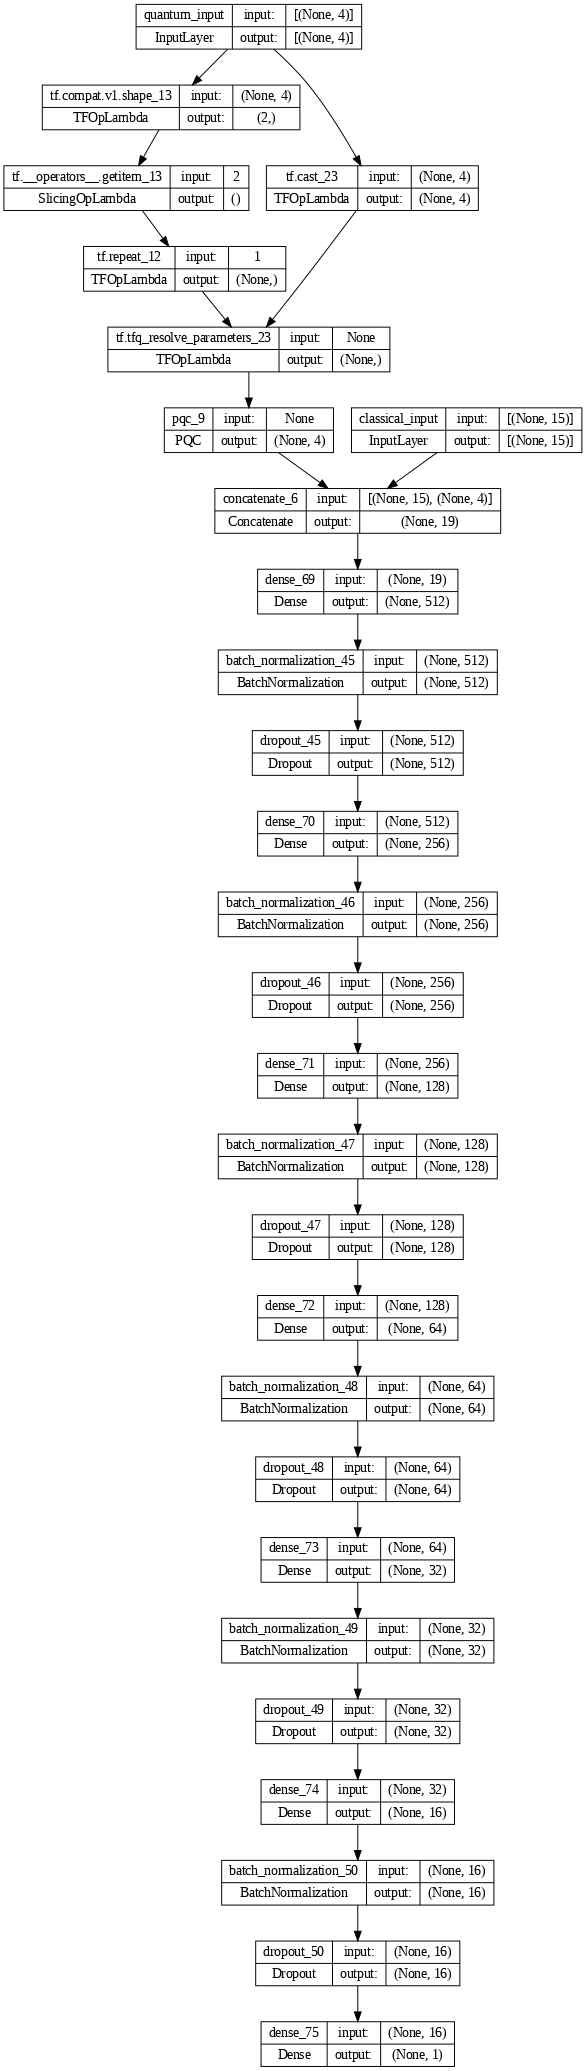

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

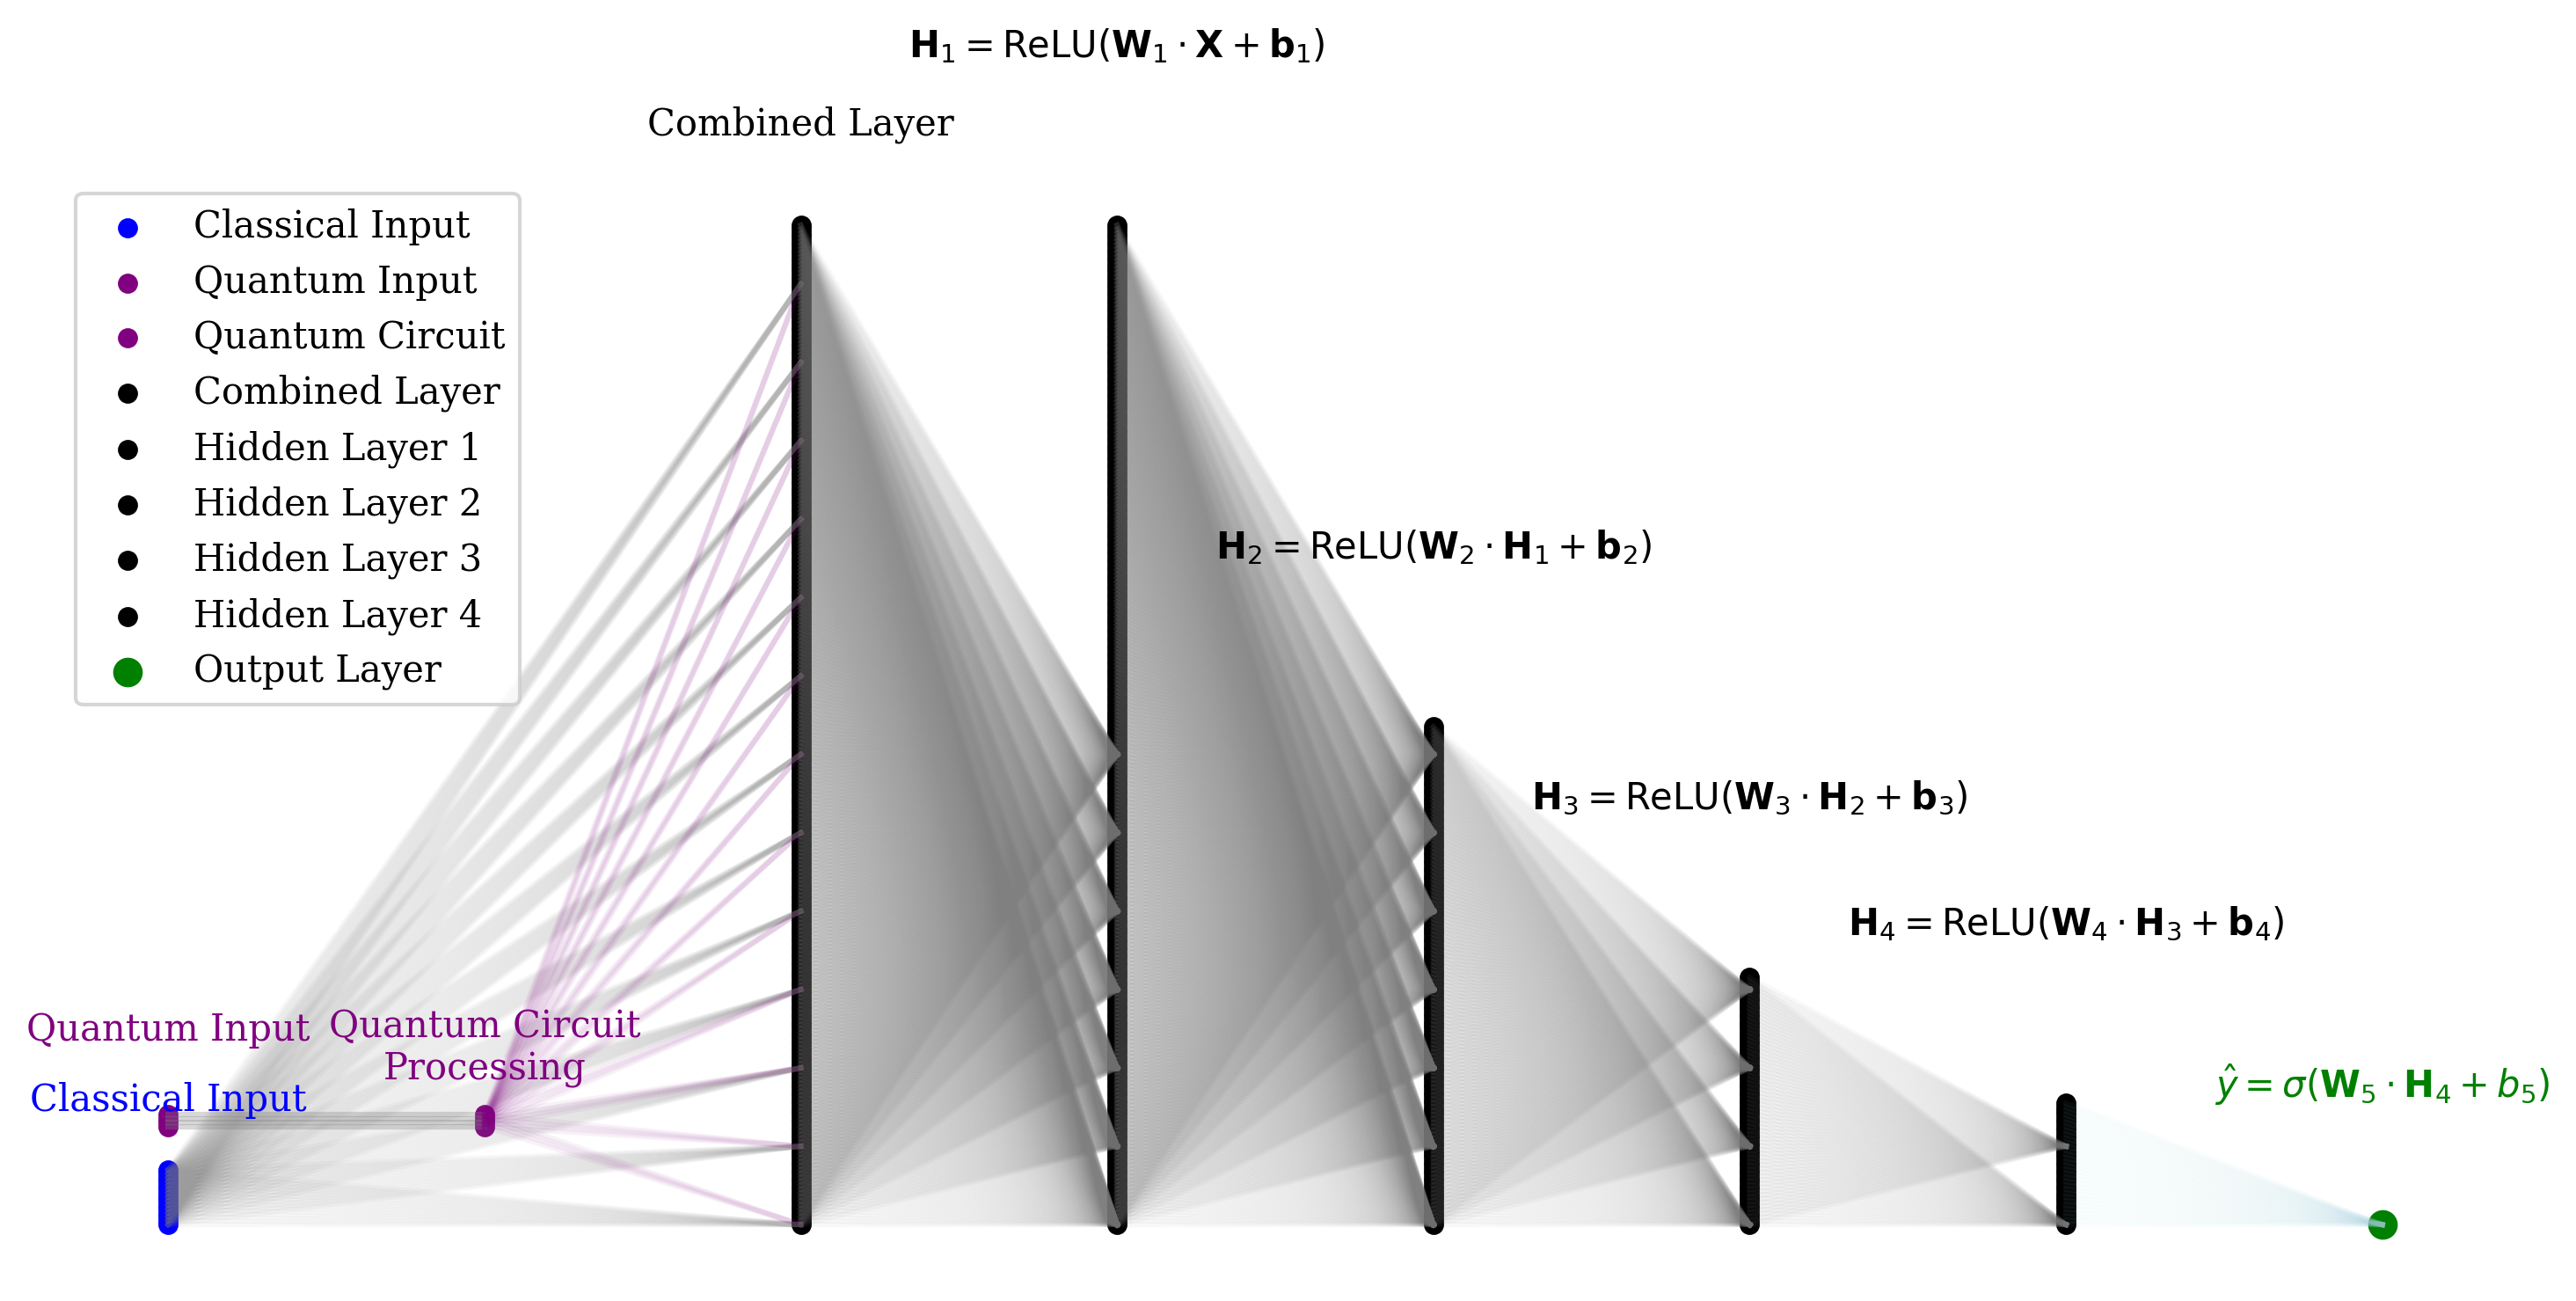

In [ ]:
import matplotlib.pyplot as plt

# Define the number of nodes for each layer
input_nodes_classical = 15
input_nodes_quantum = 4
hidden_nodes_layer1 = 256
hidden_nodes_layer2 = 128
hidden_nodes_layer3 = 64
hidden_nodes_layer4 = 32
output_nodes = 1

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Classical input layer nodes
for i in range(input_nodes_classical):
    ax.scatter(0, i, color='blue', s=20, label='Classical Input' if i == 0 else "")

# Quantum input layer nodes
for i in range(input_nodes_quantum):
    ax.scatter(0, input_nodes_classical + 10 + i, color='purple', s=20, label='Quantum Input' if i == 0 else "")

# Quantum circuit layer
for i in range(input_nodes_quantum):
    ax.scatter(1, input_nodes_classical + 10 + i, color='purple', s=20, label='Quantum Circuit' if i == 0 else "")
    ax.plot([0, 1], [input_nodes_classical + 10 + i, input_nodes_classical + 10 + i], color='gray', alpha=0.3)

# Combined layer nodes
for i in range(hidden_nodes_layer1):
    ax.scatter(2, i, color='k', s=20, label='Combined Layer' if i == 0 else "")

# First hidden layer nodes
for i in range(hidden_nodes_layer1):
    ax.scatter(3, i, color='k', s=20, label='Hidden Layer 1' if i == 0 else "")

# Second hidden layer nodes
for i in range(hidden_nodes_layer2):
    ax.scatter(4, i, color='k', s=20, label='Hidden Layer 2' if i == 0 else "")

# Third hidden layer nodes
for i in range(hidden_nodes_layer3):
    ax.scatter(5, i, color='k', s=20, label='Hidden Layer 3' if i == 0 else "")

# Fourth hidden layer nodes
for i in range(hidden_nodes_layer4):
    ax.scatter(6, i, color='k', s=20, label='Hidden Layer 4' if i == 0 else "")

# Output layer node
ax.scatter(7, 0, color='green', s=50, label='Output Layer')

# Draw connections between layers with reduced density for clarity
connection_density = 0.05 # Adjust to improve visibility in the plot

# Connect Classical Input to Combined Layer
for i in range(input_nodes_classical):
    for j in range(0, hidden_nodes_layer1, int(1 / connection_density)):
        ax.plot([0, 2], [i, j], color='gray', alpha=0.05)

# Connect Quantum Circuit output to Combined Layer
for i in range(input_nodes_quantum):
    for j in range(0, hidden_nodes_layer1, int(1 / connection_density)):
        ax.plot([1, 2], [input_nodes_classical + 10 + i, j], color='purple', alpha=0.05)

# Connections between Combined and Hidden Layer 1
for i in range(hidden_nodes_layer1):
    for j in range(0, hidden_nodes_layer2, int(1 / connection_density)):
        ax.plot([2, 3], [i, j], color='gray', alpha=0.05)

# Connections between Hidden Layer 1 and Hidden Layer 2
for i in range(hidden_nodes_layer1):
    for j in range(0, hidden_nodes_layer2, int(1 / connection_density)):
        ax.plot([3, 4], [i, j], color='gray', alpha=0.05)

# Connections between Hidden Layer 2 and Hidden Layer 3
for i in range(hidden_nodes_layer2):
    for j in range(0, hidden_nodes_layer3, int(1 / connection_density)):
        ax.plot([4, 5], [i, j], color='gray', alpha=0.05)

# Connections between Hidden Layer 3 and Hidden Layer 4
for i in range(hidden_nodes_layer3):
    for j in range(0, hidden_nodes_layer4, int(1 / connection_density)):
        ax.plot([5, 6], [i, j], color='gray', alpha=0.05)

# Connections between Hidden Layer 4 and Output Layer
for i in range(hidden_nodes_layer4):
    ax.plot([6, 7], [i, 0], color='lightblue', alpha=0.05)


eq1 = r'$\mathbf{H}_1 = \text{ReLU}(\mathbf{W}_1 \cdot \mathbf{X} + \mathbf{b}_1)$'
eq2 = r'$\mathbf{H}_2 = \text{ReLU}(\mathbf{W}_2 \cdot \mathbf{H}_1 + \mathbf{b}_2)$'
eq3 = r'$\mathbf{H}_3 = \text{ReLU}(\mathbf{W}_3 \cdot \mathbf{H}_2 + \mathbf{b}_3)$'
eq4 = r'$\mathbf{H}_4 = \text{ReLU}(\mathbf{W}_4 \cdot \mathbf{H}_3 + \mathbf{b}_4)$'
eq5 = r'$\hat{y} = \sigma(\mathbf{W}_5 \cdot \mathbf{H}_4 + b_5)$'

ax.text(0, input_nodes_classical + 12, 'Classical Input', fontsize=10, va='bottom', ha='center', color='blue')
ax.text(0, input_nodes_classical + 30, 'Quantum Input', fontsize=10, va='bottom', ha='center', color='purple')
ax.text(1, input_nodes_classical + 20, 'Quantum Circuit\nProcessing', fontsize=10, va='bottom', ha='center', color='purple')
ax.text(2, hidden_nodes_layer1 + 20, 'Combined Layer', fontsize=10, va='bottom', ha='center')

ax.text(3, hidden_nodes_layer1 + 40, eq1, fontsize=10, va='bottom', ha='center')
ax.text(4, hidden_nodes_layer2 + 40, eq2, fontsize=10, va='bottom', ha='center')
ax.text(5, hidden_nodes_layer3 + 40, eq3, fontsize=10, va='bottom', ha='center')
ax.text(6, hidden_nodes_layer4 + 40, eq4, fontsize=10, va='bottom', ha='center')
ax.text(7, 30, eq5, fontsize=10, va='bottom', ha='center', color='green')
ax.legend(loc='upper left')
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 100

X_train_array = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train_array = y_train.to_numpy().reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'classical_input': X_train_array, 'quantum_input': X_train_quantum}, y_train_array)
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

initial_bias = np.log([pos/neg])
initial_bias

Examples:
    Total: 33500
    Positive: 336 (1.00% of total)



array([-4.59210907])

In [ ]:
X_train_array = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train_array = y_train.to_numpy().reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'classical_input': X_train_array, 'quantum_input': X_train_quantum}, y_train_array)
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
X_test_array = X_test.to_numpy() if isinstance(X_test_normalized, pd.DataFrame) else X_test
y_test_array = y_test.to_numpy().reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test
num_samples_test = X_test_normalized.shape[0]
X_test_quantum = np.zeros((num_samples_test, num_qubits))
validation_dataset = tf.data.Dataset.from_tensor_slices(
    ({'classical_input': X_test_array, 'quantum_input': X_test_quantum}, y_test_array)
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
X_test_array = X_test.to_numpy() if isinstance(X_test_normalized, pd.DataFrame) else X_test
y_test_array = y_test.to_numpy().reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test
print("X_test shape:", X_test_array.shape)
print("Test labels shape:", y_test_array.shape)

X_test shape: (16500, 15)
Test labels shape: (16500, 1)


In [ ]:
num_samples_test = X_test_normalized.shape[0]
X_test_quantum = np.zeros((num_samples_test, num_qubits))
print(X_test_quantum.shape)

(16500, 4)


In [ ]:
validation_dataset = tf.data.Dataset.from_tensor_slices(
    ({'classical_input': X_test_array, 'quantum_input': X_test_quantum}, y_test_array)
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
import os, tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

In [ ]:
def plot_loss(history, label, n):
  colors = ['blue', 'green', 'red', 'orange']
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

In [ ]:
# plot_loss(zero_bias_history, "Zero Bias", 0)
# plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
def plot_metrics(history):
  colors = ['blue', 'green', 'red', 'orange']
  metrics = ['loss', 'prc', 'precision', 'recall']

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend(), plt.grid()
    plt.tight_layout()

# plot_metrics(baseline_history)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
    predicted_labels = (predictions > threshold).astype(int)
    cm = confusion_matrix(labels, predicted_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f'Hybrid Confusion Matrix @ {threshold:.2f}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    tn, fp, fn, tp = cm.ravel()

    print(f'Correctly predicted "No Backorder" (True Negatives): {tn}')
    print(f'Incorrectly predicted "Backorder" (False Positives): {fp} (false alarm)')
    print(f'Incorrectly predicted "No Backorder" (False Negatives): {fn} (missed backorder)')
    print(f'Correctly predicted "Backorder" (True Positives): {tp}')
    print(f'Total Actual Backorders: {np.sum(cm[1])}')

    plt.show()

## Weighted

In [ ]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 33500
    Positive: 336 (1.00% of total)

Weight for class 0: 0.51
Weight for class 1: 49.85


## **Reqd no. of layers**

Epoch 1/100
33/33 [==============================] - 97s 3s/step - loss: 0.8460 - brier_score: 0.3581 - tp: 489.0000 - fp: 32146.0000 - tn: 22419.0000 - fn: 66.0000 - accuracy: 0.4156 - precision: 0.0150 - recall: 0.8811 - auc: 0.7380 - prc: 0.0314 - val_loss: 1.2464 - val_brier_score: 0.5071 - val_tp: 166.0000 - val_fp: 16334.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0101 - val_precision: 0.0101 - val_recall: 1.0000 - val_auc: 0.5089 - val_prc: 0.0146
Epoch 2/100
33/33 [==============================] - 83s 3s/step - loss: 0.7005 - brier_score: 0.4059 - tp: 330.0000 - fp: 24035.0000 - tn: 9129.0000 - fn: 6.0000 - accuracy: 0.2824 - precision: 0.0135 - recall: 0.9821 - auc: 0.8501 - prc: 0.0508 - val_loss: 1.0250 - val_brier_score: 0.4108 - val_tp: 166.0000 - val_fp: 16333.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0101 - val_precision: 0.0101 - val_recall: 1.0000 - val_auc: 0.7338 - val_prc: 0.0612
Epoch 4/100
33/33 [===========================

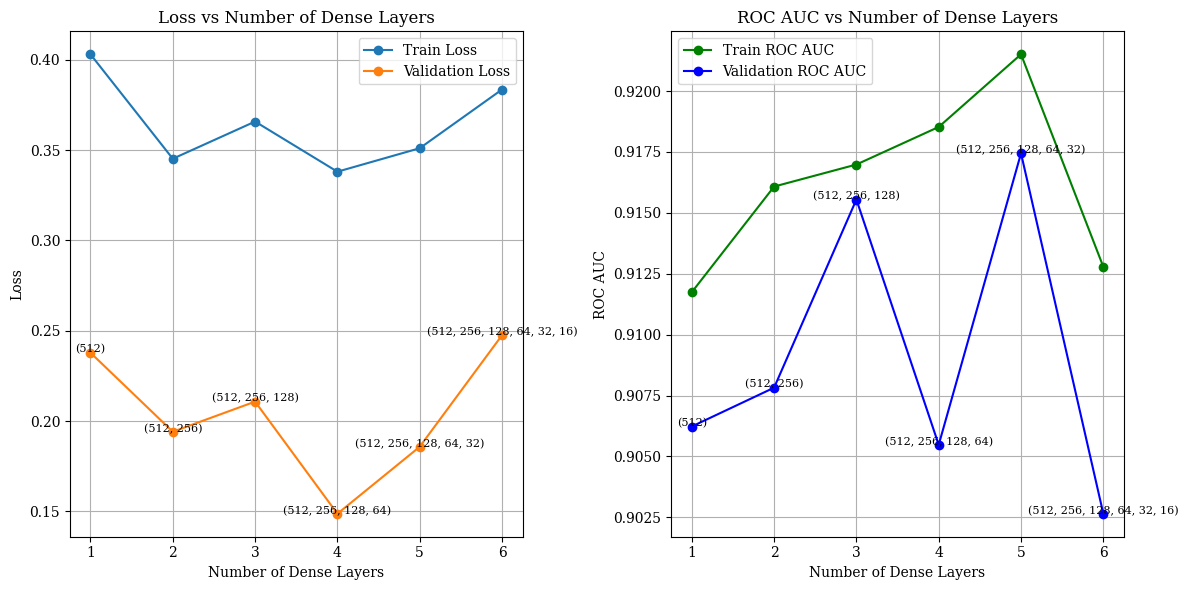

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

performance_metrics = {
    'num_layers': [],
    'train_loss': [],
    'val_loss': [],
    'train_roc_auc': [],
    'val_roc_auc': [],
    'val_prc_auc': [] }

num_dense_layers = [6, 5, 4, 3, 2, 1]

neurons_config = {
    6: [512, 256, 128, 64, 32, 16],
    5: [512, 256, 128, 64, 32],
    4: [512, 256, 128, 64],
    3: [512, 256, 128],
    2: [512, 256],
    1: [512]}

for layers in num_dense_layers:
    def hybrid_model_modified(classical_input_dim, quantum_input_dim, num_layers, metrics=METRICS, output_bias=None):
        random_uniform_initializer = tf.keras.initializers.RandomUniform(seed=42)
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)

        classical_input = tf.keras.layers.Input(shape=(classical_input_dim,), name='classical_input')
        quantum_input = tf.keras.layers.Input(shape=(quantum_input_dim,), name='quantum_input')
        batch_size = tf.shape(quantum_input)[0]
        tiled_circuits = tfq.convert_to_tensor([quantum_circuit])
        tiled_up_circuits = tf.repeat(tiled_circuits, repeats=batch_size, axis=0)
        symbol_names = [str(s) for s in symbols]
        resolved_circuits = tfq.resolve_parameters(tiled_up_circuits, symbol_names, quantum_input)
        quantum_output = quantum_layer(resolved_circuits)

        combined = tf.keras.layers.Concatenate()([classical_input, quantum_output])

        x = combined
        for i in range(num_layers):
            x = tf.keras.layers.Dense(neurons_config[layers][i], activation='LeakyReLU',
                                      kernel_initializer=random_uniform_initializer)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Dropout(0.1 if i < num_layers - 1 else 0.5)(x)

        output = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
        model = tf.keras.Model(inputs=[classical_input, quantum_input], outputs=output)

        model.compile(
            optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
        return model

    model = hybrid_model_modified(classical_input_dim=input_dim, quantum_input_dim=quantum_input_dim, num_layers=layers)
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=validation_dataset,
        callbacks=[early_stopping()],
        class_weight=class_weight)

    train_preds = model.predict(train_dataset.map(lambda x, y: x))
    val_preds = model.predict(validation_dataset.map(lambda x, y: x))

    train_true = np.concatenate([y.numpy() for _, y in train_dataset])
    val_true = np.concatenate([y.numpy() for _, y in validation_dataset])

    train_roc_auc = roc_auc_score(train_true, train_preds)
    val_roc_auc = roc_auc_score(val_true, val_preds)

    prc_auc = average_precision_score(val_true, val_preds)

    performance_metrics['num_layers'].append(layers)
    performance_metrics['train_loss'].append(min(history.history['loss']))
    performance_metrics['val_loss'].append(min(history.history['val_loss']))
    performance_metrics['train_roc_auc'].append(train_roc_auc)
    performance_metrics['val_roc_auc'].append(val_roc_auc)  # Validation ROC AUC
    performance_metrics['val_prc_auc'].append(prc_auc)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(performance_metrics['num_layers'], performance_metrics['train_loss'], label='Train Loss', marker='o')
plt.plot(performance_metrics['num_layers'], performance_metrics['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Number of Dense Layers')
plt.ylabel('Loss')
plt.title('Loss vs Number of Dense Layers')
plt.legend()
plt.grid()

for i, layers in enumerate(performance_metrics['num_layers']):
    layer_neurons = neurons_config[layers]
    neurons_str = ', '.join([str(n) for n in layer_neurons])
    plt.text(layers, performance_metrics['val_loss'][i], f"({neurons_str})", fontsize=8, ha='center')

plt.subplot(1, 2, 2)
plt.plot(performance_metrics['num_layers'], performance_metrics['train_roc_auc'], label='Train ROC AUC', marker='o', color='green')
plt.plot(performance_metrics['num_layers'], performance_metrics['val_roc_auc'], label='Validation ROC AUC', marker='o', color='blue')
plt.xlabel('Number of Dense Layers')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs Number of Dense Layers')
plt.legend()
plt.grid()

for i, layers in enumerate(performance_metrics['num_layers']):
    layer_neurons = neurons_config[layers]
    neurons_str = ', '.join([str(n) for n in layer_neurons])
    plt.text(layers, performance_metrics['val_roc_auc'][i], f"({neurons_str})", fontsize=8, ha='center')

plt.tight_layout()
plt.show()

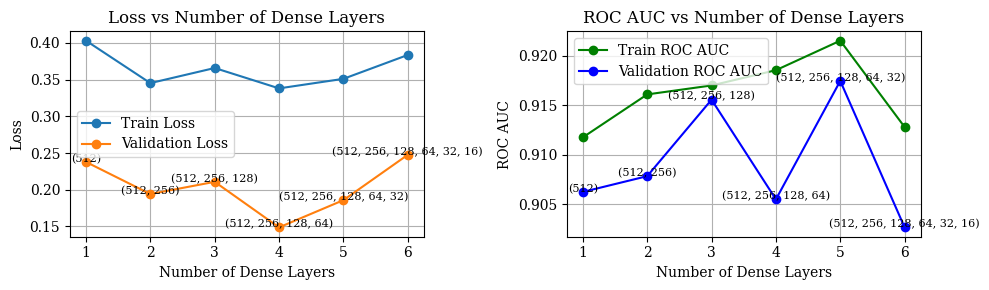

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(performance_metrics['num_layers'], performance_metrics['train_loss'], label='Train Loss', marker='o')
plt.plot(performance_metrics['num_layers'], performance_metrics['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Number of Dense Layers')
plt.ylabel('Loss')
plt.title('Loss vs Number of Dense Layers')
plt.legend()
plt.grid()

for i, layers in enumerate(performance_metrics['num_layers']):
    layer_neurons = neurons_config[layers]
    neurons_str = ', '.join([str(n) for n in layer_neurons])
    plt.text(layers, performance_metrics['val_loss'][i], f"({neurons_str})", fontsize=8, ha='center')

plt.subplot(1, 2, 2)
plt.plot(performance_metrics['num_layers'], performance_metrics['train_roc_auc'], label='Train ROC AUC', marker='o', color='green')
plt.plot(performance_metrics['num_layers'], performance_metrics['val_roc_auc'], label='Validation ROC AUC', marker='o', color='blue')
plt.xlabel('Number of Dense Layers')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs Number of Dense Layers')
plt.legend()
plt.grid()

for i, layers in enumerate(performance_metrics['num_layers']):
    layer_neurons = neurons_config[layers]
    neurons_str = ', '.join([str(n) for n in layer_neurons])
    plt.text(layers, performance_metrics['val_roc_auc'][i], f"({neurons_str})", fontsize=8, ha='center')
plt.tight_layout()
plt.show()

## **Applying 3 layes [512, 256, 128]**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 quantum_input (InputLayer)  [(None, 4)]                  0         []                            
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (2,)                         0         ['quantum_input[0][0]']       
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.getitem (  ()                           0         ['tf.compat.v1.shape[0][0]']  
 SlicingOpLambda)                                                                                 
                                                                                              

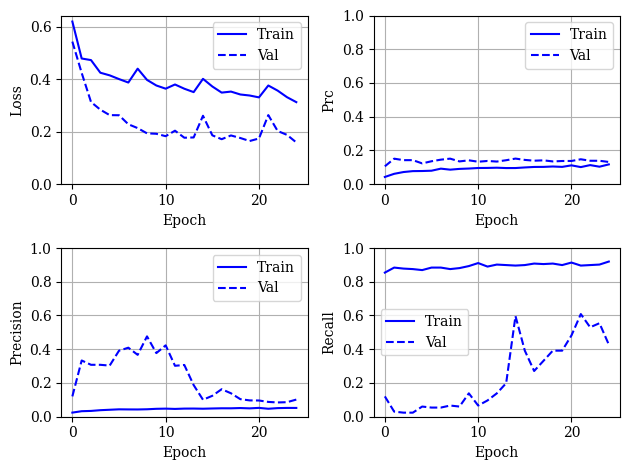

In [ ]:
import os
from tensorflow.keras.optimizers import Adam

def hybrid_model(classical_input_dim, quantum_input_dim, metrics=METRICS, output_bias=None):
    random_uniform_initializer = tf.keras.initializers.RandomUniform(seed=42)
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    # Classical input
    classical_input = tf.keras.layers.Input(shape=(classical_input_dim,), name='classical_input')

    # Quantum input
    quantum_input = tf.keras.layers.Input(shape=(quantum_input_dim,), name='quantum_input')
    batch_size = tf.shape(quantum_input)[0]
    tiled_circuits = tfq.convert_to_tensor([quantum_circuit])
    tiled_up_circuits = tf.repeat(tiled_circuits, repeats=batch_size, axis=0)
    symbol_names = [str(s) for s in symbols]
    resolved_circuits = tfq.resolve_parameters(tiled_up_circuits, symbol_names, quantum_input)
    quantum_output = quantum_layer(resolved_circuits)

    # Combine inputs
    combined = tf.keras.layers.Concatenate()([classical_input, quantum_output])

    # Neural network layers
    x = tf.keras.layers.Dense(512, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(256, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(x) # Changed 'LeakyRelu' to 'LeakyReLU'
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='LeakyReLU', kernel_initializer=random_uniform_initializer)(x) # Changed 'LeakyRelu' to 'LeakyReLU'
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
    model = tf.keras.Model(inputs=[classical_input, quantum_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model

def early_stopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_prc',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

input_dim = X_train_normalized.shape[1]
quantum_input_dim = num_qubits

model = hybrid_model(input_dim, quantum_input_dim)
print(model.summary())

BATCH_SIZE = 1024
EPOCHS = 100

X_train_array = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train_array = y_train.to_numpy().reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'classical_input': X_train_array, 'quantum_input': X_train_quantum}, y_train_array)
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

initial_bias = np.log([pos/neg])

X_test_array = X_test.to_numpy() if isinstance(X_test_normalized, pd.DataFrame) else X_test
y_test_array = y_test.to_numpy().reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test
num_samples_test = X_test_normalized.shape[0]
X_test_quantum = np.zeros((num_samples_test, num_qubits))

validation_dataset = tf.data.Dataset.from_tensor_slices(
    ({'classical_input': X_test_array, 'quantum_input': X_test_quantum}, y_test_array)
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

def plot_loss(history, label, n):
  colors = ['blue', 'green', 'red', 'orange']
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

def plot_metrics(history):
  colors = ['blue', 'green', 'red', 'orange']
  metrics = ['loss', 'prc', 'precision', 'recall']

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend(), plt.grid()
    plt.tight_layout()

weighted_model = hybrid_model(classical_input_dim=input_dim,
                              quantum_input_dim=quantum_input_dim)
model.save_weights('weights_only.h5')
if not os.path.exists('weights_only.h5'):
    print("Error: weights_only.h5 not found. Please ensure the file exists in the current directory or provide the correct path.")
else:
    weighted_model.load_weights('weights_only.h5', skip_mismatch=True, by_name=True)


optimizer = Adam(learning_rate=0.001)
weighted_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=METRICS)

weighted_history = weighted_model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    callbacks=[early_stopping()],
    class_weight=class_weight)

plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(
    [X_train_array, X_train_quantum],
    batch_size=BATCH_SIZE)

test_predictions_weighted = weighted_model.predict(
    [X_test_array, X_test_quantum],
    batch_size=BATCH_SIZE)

17/17 [==============================] - 19s 1s/step


loss :  0.26087772846221924
brier_score :  0.045460883527994156
tp :  99.0
fp :  885.0
tn :  15449.0
fn :  67.0
accuracy :  0.9423030018806458
precision :  0.10060975700616837
recall :  0.5963855385780334
auc :  0.9172974824905396
prc :  0.15188990533351898

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     16334
           1       0.10      0.60      0.17       166

    accuracy                           0.94     16500
   macro avg       0.55      0.77      0.57     16500
weighted avg       0.99      0.94      0.96     16500



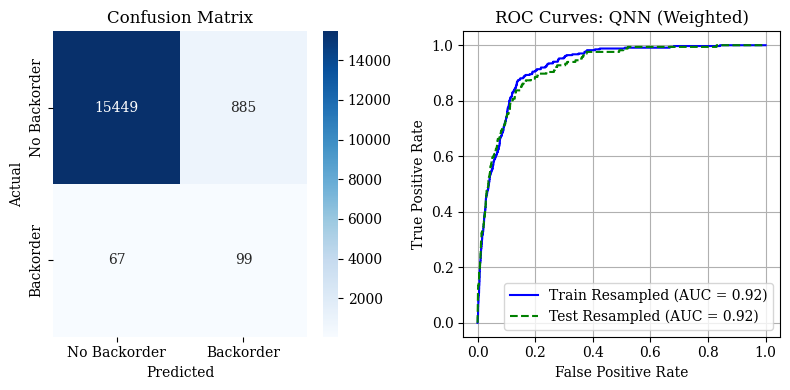

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

weighted_results = weighted_model.evaluate([X_test_array, X_test_quantum],
                                           y_test_array,
                                           batch_size=BATCH_SIZE,
                                           verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

test_predictions_weighted_binary = np.where(test_predictions_weighted > 0.5, 1, 0)

print("Classification Report:")
print(classification_report(y_test_array, test_predictions_weighted_binary))

cm = confusion_matrix(y_test_array, test_predictions_weighted_binary)
colors = ['b', 'g']
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No Backorder', 'Backorder'],
    yticklabels=['No Backorder', 'Backorder'],
    ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC Curves
def plot_roc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')


plot_roc("Train Resampled", y_train_array, train_predictions_weighted, color=colors[0], ax=axes[1])
plot_roc("Test Resampled", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--', ax=axes[1])

axes[1].set_title('ROC Curves: QNN (Weighted)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import os
from tensorflow.keras.optimizers import Adam

weighted_model = hybrid_model(classical_input_dim=input_dim,
                              quantum_input_dim=quantum_input_dim)
model.save_weights('weights_only.h5')
if not os.path.exists('weights_only.h5'):
    print("Error: weights_only.h5 not found. Please ensure the file exists in the current directory or provide the correct path.")
else:
    weighted_model.load_weights('weights_only.h5', skip_mismatch=True, by_name=True)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'classical_input': X_train_array, 'quantum_input': X_train_quantum}, y_train_array)
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    ({'classical_input': X_test_array, 'quantum_input': X_test_quantum}, y_test_array)
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

optimizer = Adam(learning_rate=0.001)
weighted_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=METRICS)

weighted_history = weighted_model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    callbacks=[early_stopping()],
    class_weight=class_weight)

Epoch 1/100
33/33 [==============================] - 68s 2s/step - loss: 1.0396 - brier_score: 0.5719 - tp: 325.0000 - fp: 29038.0000 - tn: 4126.0000 - fn: 11.0000 - accuracy: 0.1329 - precision: 0.0111 - recall: 0.9673 - auc: 0.7648 - prc: 0.0333 - val_loss: 1.5908 - val_brier_score: 0.6323 - val_tp: 166.0000 - val_fp: 16334.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0101 - val_precision: 0.0101 - val_recall: 1.0000 - val_auc: 0.7787 - val_prc: 0.0455
Epoch 2/100
33/33 [==============================] - 58s 2s/step - loss: 0.8937 - brier_score: 0.5367 - tp: 332.0000 - fp: 29666.0000 - tn: 3498.0000 - fn: 4.0000 - accuracy: 0.1143 - precision: 0.0111 - recall: 0.9881 - auc: 0.8171 - prc: 0.0382 - val_loss: 1.3703 - val_brier_score: 0.5553 - val_tp: 166.0000 - val_fp: 16333.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0101 - val_precision: 0.0101 - val_recall: 1.0000 - val_auc: 0.7458 - val_prc: 0.0630
Epoch 3/100
33/33 [============================

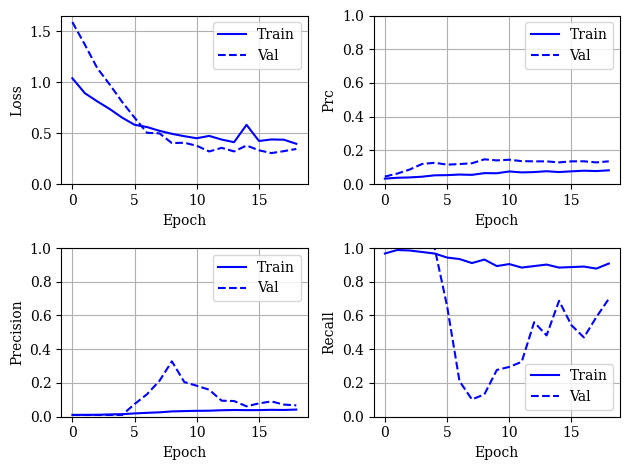

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(
    [X_train_array, X_train_quantum],
    batch_size=BATCH_SIZE)

test_predictions_weighted = weighted_model.predict(
    [X_test_array, X_test_quantum],
    batch_size=BATCH_SIZE)

17/17 [==============================] - 15s 884ms/step


loss :  0.40368083119392395
brier_score :  0.09358531981706619
tp :  22.0
fp :  45.0
tn :  16289.0
fn :  144.0
accuracy :  0.9885454773902893
precision :  0.3283582031726837
recall :  0.1325301229953766
auc :  0.915306568145752
prc :  0.1475772112607956

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16334
           1       0.33      0.13      0.19       166

    accuracy                           0.99     16500
   macro avg       0.66      0.56      0.59     16500
weighted avg       0.98      0.99      0.99     16500



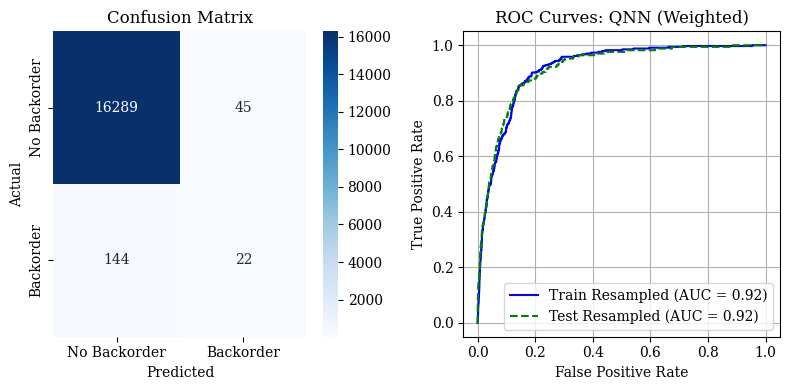

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

weighted_results = weighted_model.evaluate([X_test_array, X_test_quantum],
                                           y_test_array,
                                           batch_size=BATCH_SIZE,
                                           verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

test_predictions_weighted_binary = np.where(test_predictions_weighted > 0.5, 1, 0)
print("Classification Report:")
print(classification_report(y_test_array, test_predictions_weighted_binary))

cm = confusion_matrix(y_test_array, test_predictions_weighted_binary)

colors = ['b', 'g']
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No Backorder', 'Backorder'],
    yticklabels=['No Backorder', 'Backorder'],
    ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# 4. ROC Curves
def plot_roc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')


plot_roc("Train Resampled", y_train_array, train_predictions_weighted, color=colors[0], ax=axes[1])
plot_roc("Test Resampled", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--', ax=axes[1])

axes[1].set_title('ROC Curves: QNN (Weighted)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

loss :  0.40368083119392395
brier_score :  0.09358531981706619
tp :  22.0
fp :  45.0
tn :  16289.0
fn :  144.0
accuracy :  0.9885454773902893
precision :  0.3283582031726837
recall :  0.1325301229953766
auc :  0.915306568145752
prc :  0.1475772112607956

Correctly predicted "No Backorder" (True Negatives): 16289
Incorrectly predicted "Backorder" (False Positives): 45 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 144 (missed backorder)
Correctly predicted "Backorder" (True Positives): 22
Total Actual Backorders: 166


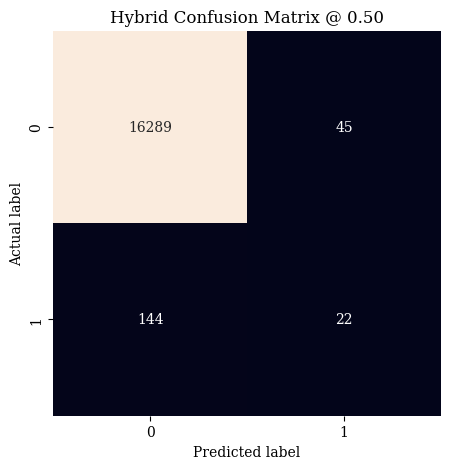

In [ ]:
weighted_results = weighted_model.evaluate([X_test_array, X_test_quantum],
                                           y_test_array,
                                           batch_size=BATCH_SIZE,
                                           verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()
plot_cm(y_test_array, test_predictions_weighted)

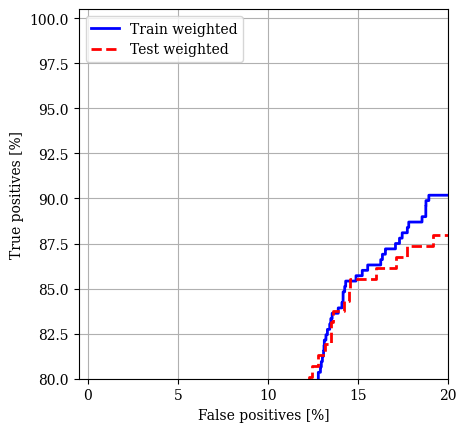

In [ ]:
import matplotlib.pyplot as plt
import sklearn.metrics

colors = ['blue', 'red']

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 20])
    plt.ylim([80, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_roc("Train weighted", y_train_array, train_predictions_weighted, color=colors[0])
plot_roc("Test weighted", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='upper left')
plt.show()

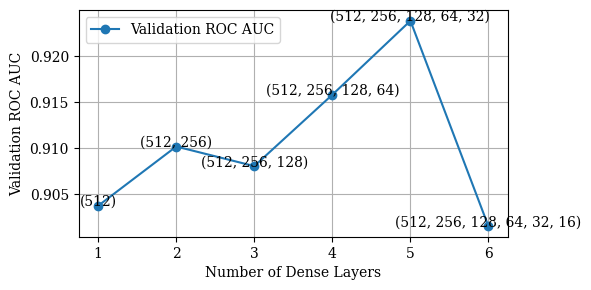

In [ ]:
plt.figure(figsize=(6, 3))

# ROC AUC vs Number of Dense Layers
plt.plot(performance_metrics['num_layers'], performance_metrics['val_roc_auc'], label='Validation ROC AUC', marker='o')
plt.xlabel('Number of Dense Layers')
plt.ylabel('Validation ROC AUC')
plt.title('ROC AUC vs Number of Dense Layers')
plt.grid()

for i, layers in enumerate(performance_metrics['num_layers']):
    layer_neurons = neurons_config[layers]
    neurons_str = ', '.join([str(n) for n in layer_neurons])
    plt.text(layers, performance_metrics['val_roc_auc'][i], f"({neurons_str})", fontsize=10, ha='center')

plt.legend()
plt.tight_layout()
plt.show()


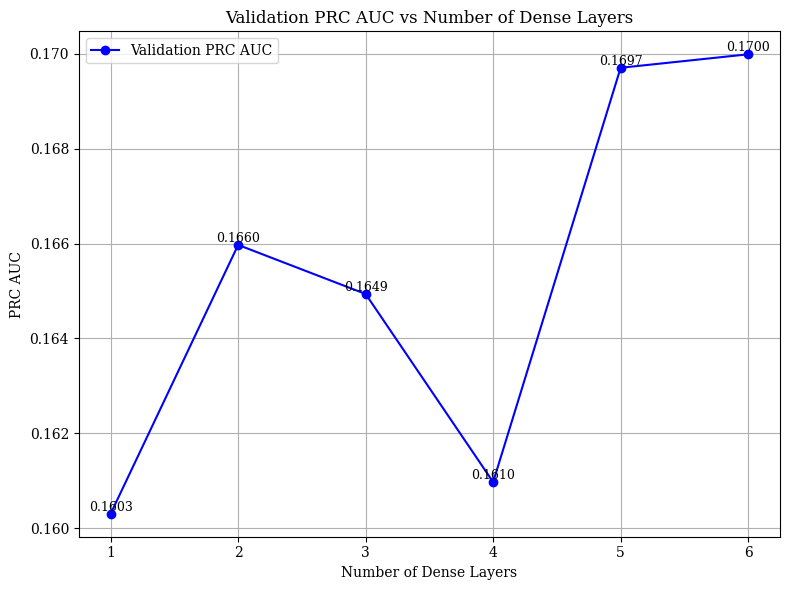

In [ ]:
import matplotlib.pyplot as plt

num_layers = performance_metrics['num_layers']
prc_auc_values = performance_metrics['val_prc_auc']

plt.figure(figsize=(8, 6))
plt.plot(num_layers, prc_auc_values, marker='o', label='Validation PRC AUC', color='blue')
plt.xlabel('Number of Dense Layers')
plt.ylabel('PRC AUC')
plt.title('Validation PRC AUC vs Number of Dense Layers')
plt.grid(True)
plt.legend()
plt.tight_layout()

for i, prc_auc in enumerate(prc_auc_values):
    plt.text(num_layers[i], prc_auc, f"{prc_auc:.4f}", fontsize=9, ha='center', va='bottom')

plt.show()


516/516 [==============================] - 25s 48ms/step


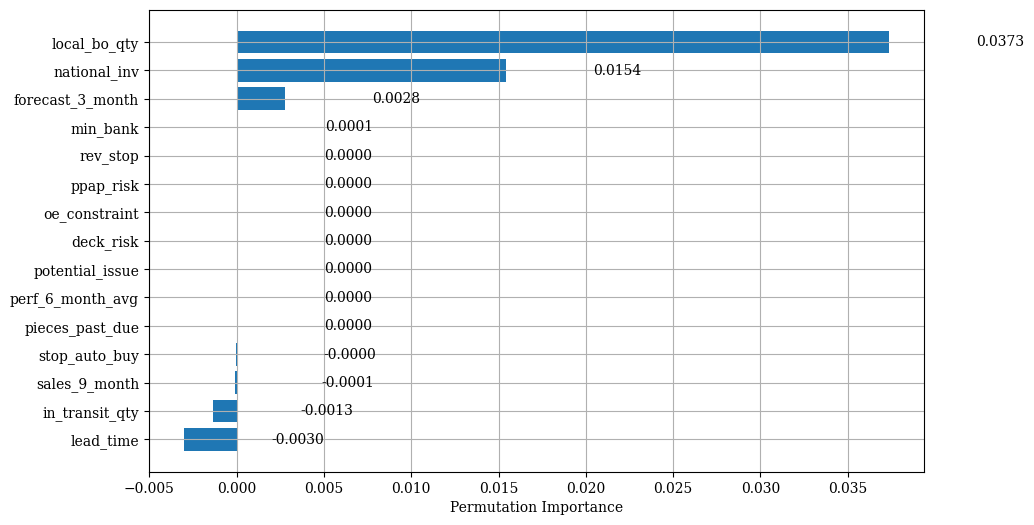

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def permutation_importance(model, X_val_classical, X_val_quantum, y_val, metric=roc_auc_score):
    baseline_score = metric(y_val, np.round(model.predict({'classical_input': X_val_classical, 'quantum_input': X_val_quantum})))

    importances = []
    for i in range(X_val_classical.shape[1]):
        X_val_permuted = X_val_classical.copy()
        np.random.shuffle(X_val_permuted[:, i])
        permuted_score = metric(y_val, np.round(model.predict({'classical_input': X_val_permuted, 'quantum_input': X_val_quantum})))
        importance = baseline_score - permuted_score
        importances.append(importance)

    return np.array(importances)


importances = permutation_importance(weighted_model, X_test_array, X_test_quantum, y_test_array)
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(np.arange(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.grid(True)

for bar, importance in zip(bars, importances[sorted_idx]):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{importance:.4f}', va='center', ha='left')

plt.show()

In [ ]:
def calculate_dynamic_threshold(fp_cost, fn_cost, model_probs, y_true):
    """
    Calculate the optimal threshold dynamically based on costs of false positives and false negatives.

    Args:
    - fp_cost (float): Cost of a false positive.
    - fn_cost (float): Cost of a false negative.
    - model_probs (array-like): Predicted probabilities from the model.
    - y_true (array-like): True labels for validation or test set.

    Returns:
    - optimal_threshold (float): The dynamically calculated threshold.
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    min_cost = float('inf')

    for threshold in thresholds:
        predictions = (model_probs >= threshold).astype(int)
        fp = np.sum((predictions == 1) & (y_true == 0))
        fn = np.sum((predictions == 0) & (y_true == 1))

        total_cost = (fp * fp_cost) + (fn * fn_cost)
        if total_cost < min_cost:
            min_cost = total_cost
            best_threshold = threshold

    return best_threshold

In [ ]:
y_val_probs = weighted_model.predict(validation_dataset)

false_positive_cost = 5
false_negative_cost = 10

optimal_threshold = calculate_dynamic_threshold(false_positive_cost, false_negative_cost, y_val_probs, y_test_array)
print(f"Optimal Threshold: {optimal_threshold}")
y_val_predictions = (y_val_probs >= optimal_threshold).astype(int)

17/17 [==============================] - 19s 1s/step
Optimal Threshold: 0.7171717171717172


## Total Cost=(FP Count×Cost of FP)+(FN Count×Cost of FN)

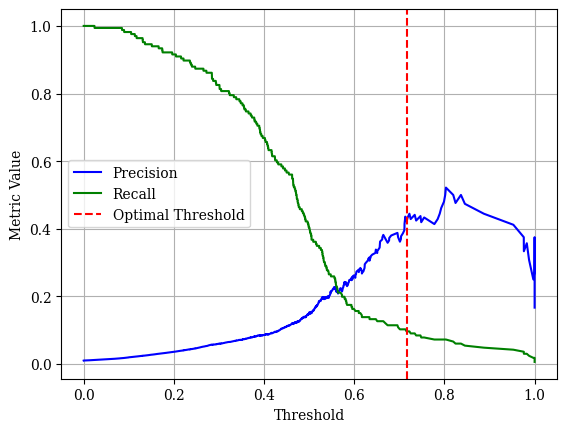

In [ ]:
# Simulate dynamic cost changes
current_fp_cost = 45*5
current_fn_cost = 144*10

dynamic_threshold = calculate_dynamic_threshold(current_fp_cost, current_fn_cost, y_val_probs, y_test_array)

new_predictions = (y_val_probs >= dynamic_threshold).astype(int)

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_array, y_val_probs)
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid()
plt.show()

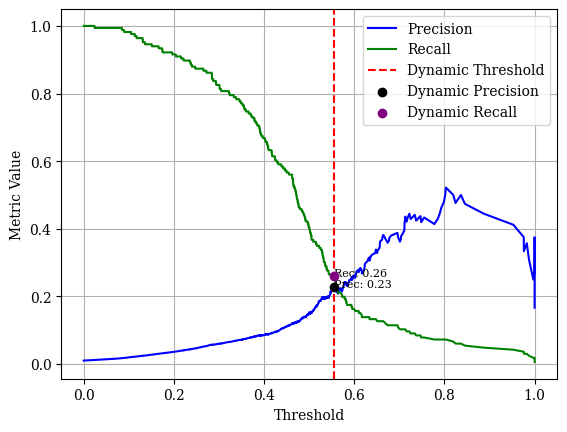

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_array, y_val_probs)

plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')

plt.axvline(x=dynamic_threshold, color='red', linestyle='--', label='Dynamic Threshold')

closest_idx = (np.abs(thresholds - dynamic_threshold)).argmin()
dynamic_precision = precision[closest_idx]
dynamic_recall = recall[closest_idx]
plt.scatter([dynamic_threshold], [dynamic_precision], color='k', label='Dynamic Precision', zorder=5)
plt.scatter([dynamic_threshold], [dynamic_recall], color='purple', label='Dynamic Recall', zorder=5)
plt.text(dynamic_threshold, dynamic_precision, f"Prec: {dynamic_precision:.2f}", fontsize=8)
plt.text(dynamic_threshold, dynamic_recall, f"Rec: {dynamic_recall:.2f}", fontsize=8)

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid()
plt.title('Precision-Recall vs Threshold (with Dynamic Threshold)')
plt.show()


In [ ]:
import numpy as np

# Assuming `precision`, `recall`, and `thresholds` arrays are defined
diff = np.abs(precision - recall)
intersection_idx = np.argmin(diff)
intersection_threshold = thresholds[intersection_idx]

print(f"Intersection Threshold: {intersection_threshold}")


Intersection Threshold: 0.5642998814582825
